<a href="https://colab.research.google.com/github/DimaKav/Tanzanian_waterpumps_project/blob/master/water_pumps_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!wget https://raw.githubusercontent.com/DimaKav/Tanzanian_waterpumps_project/master/sample_submission.csv
!wget https://raw.githubusercontent.com/DimaKav/Tanzanian_waterpumps_project/master/test_features.csv
!wget https://raw.githubusercontent.com/DimaKav/Tanzanian_waterpumps_project/master/train_features.csv
!wget https://raw.githubusercontent.com/DimaKav/Tanzanian_waterpumps_project/master/train_labels.csv

In [0]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
%config InlineBackend.figure_format='retina'
pd.set_option('display.max_columns', 500)

In [14]:
# Load necessary data
train_features = pd.read_csv('train_features.csv')
train_labels = pd.read_csv('train_labels.csv')
test_features = pd.read_csv('test_features.csv')
sample_submission = pd.read_csv('sample_submission.csv')
# Make combined df for easier processing
df = pd.concat([train_features, test_features])
train_features.shape, train_labels.shape, test_features.shape, \
sample_submission.shape, df.shape

((59400, 40), (59400, 2), (14358, 40), (14358, 2), (73758, 40))

# Exploratory analysis
Descriptive statistics and important variable distributions.

In [0]:
train_features.head(3)

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe


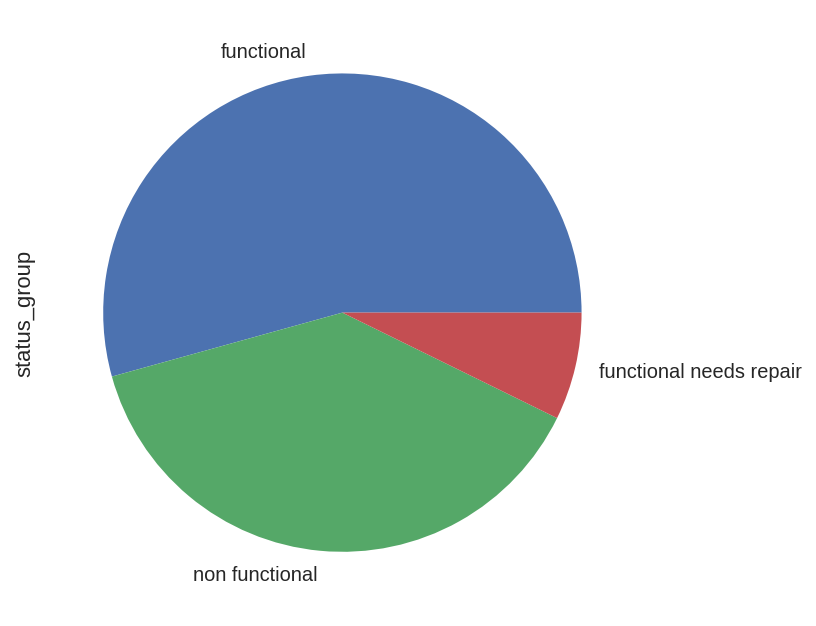

In [0]:
# Distribution of water pump status
train_labels['status_group'].value_counts().sort_values(ascending=False).plot(kind='pie');

In [0]:
train_labels['status_group'].value_counts(normalize=True)

functional                 0.543081
non functional             0.384242
functional needs repair    0.072677
Name: status_group, dtype: float64

The majority of the pumps are functinal, some are non-functional, a small minority is functional but needs repair.

In [0]:
# Pearson correlations, top 2 negative correlations
c = pd.concat([train_features,train_labels],axis=1)
object_cols = train_labels.select_dtypes('object').columns
c[object_cols] = c[object_cols].apply(lambda x: pd.factorize(x)[0])
print('Negative corrs:\n',c.corr()['status_group'].sort_values()[:2])

# Top 4 positive correlations
print('Positive corrs:\n',c.corr()['status_group'].sort_values()[-6:-2])

Negative corrs:
 gps_height   -0.096408
longitude    -0.071635
Name: status_group, dtype: float64
Positive corrs:
 id               0.003354
id               0.003354
latitude         0.021020
district_code    0.033979
Name: status_group, dtype: float64


Pearson correlation may not be meaningful here because I factorized the categories without much attention to their rank.

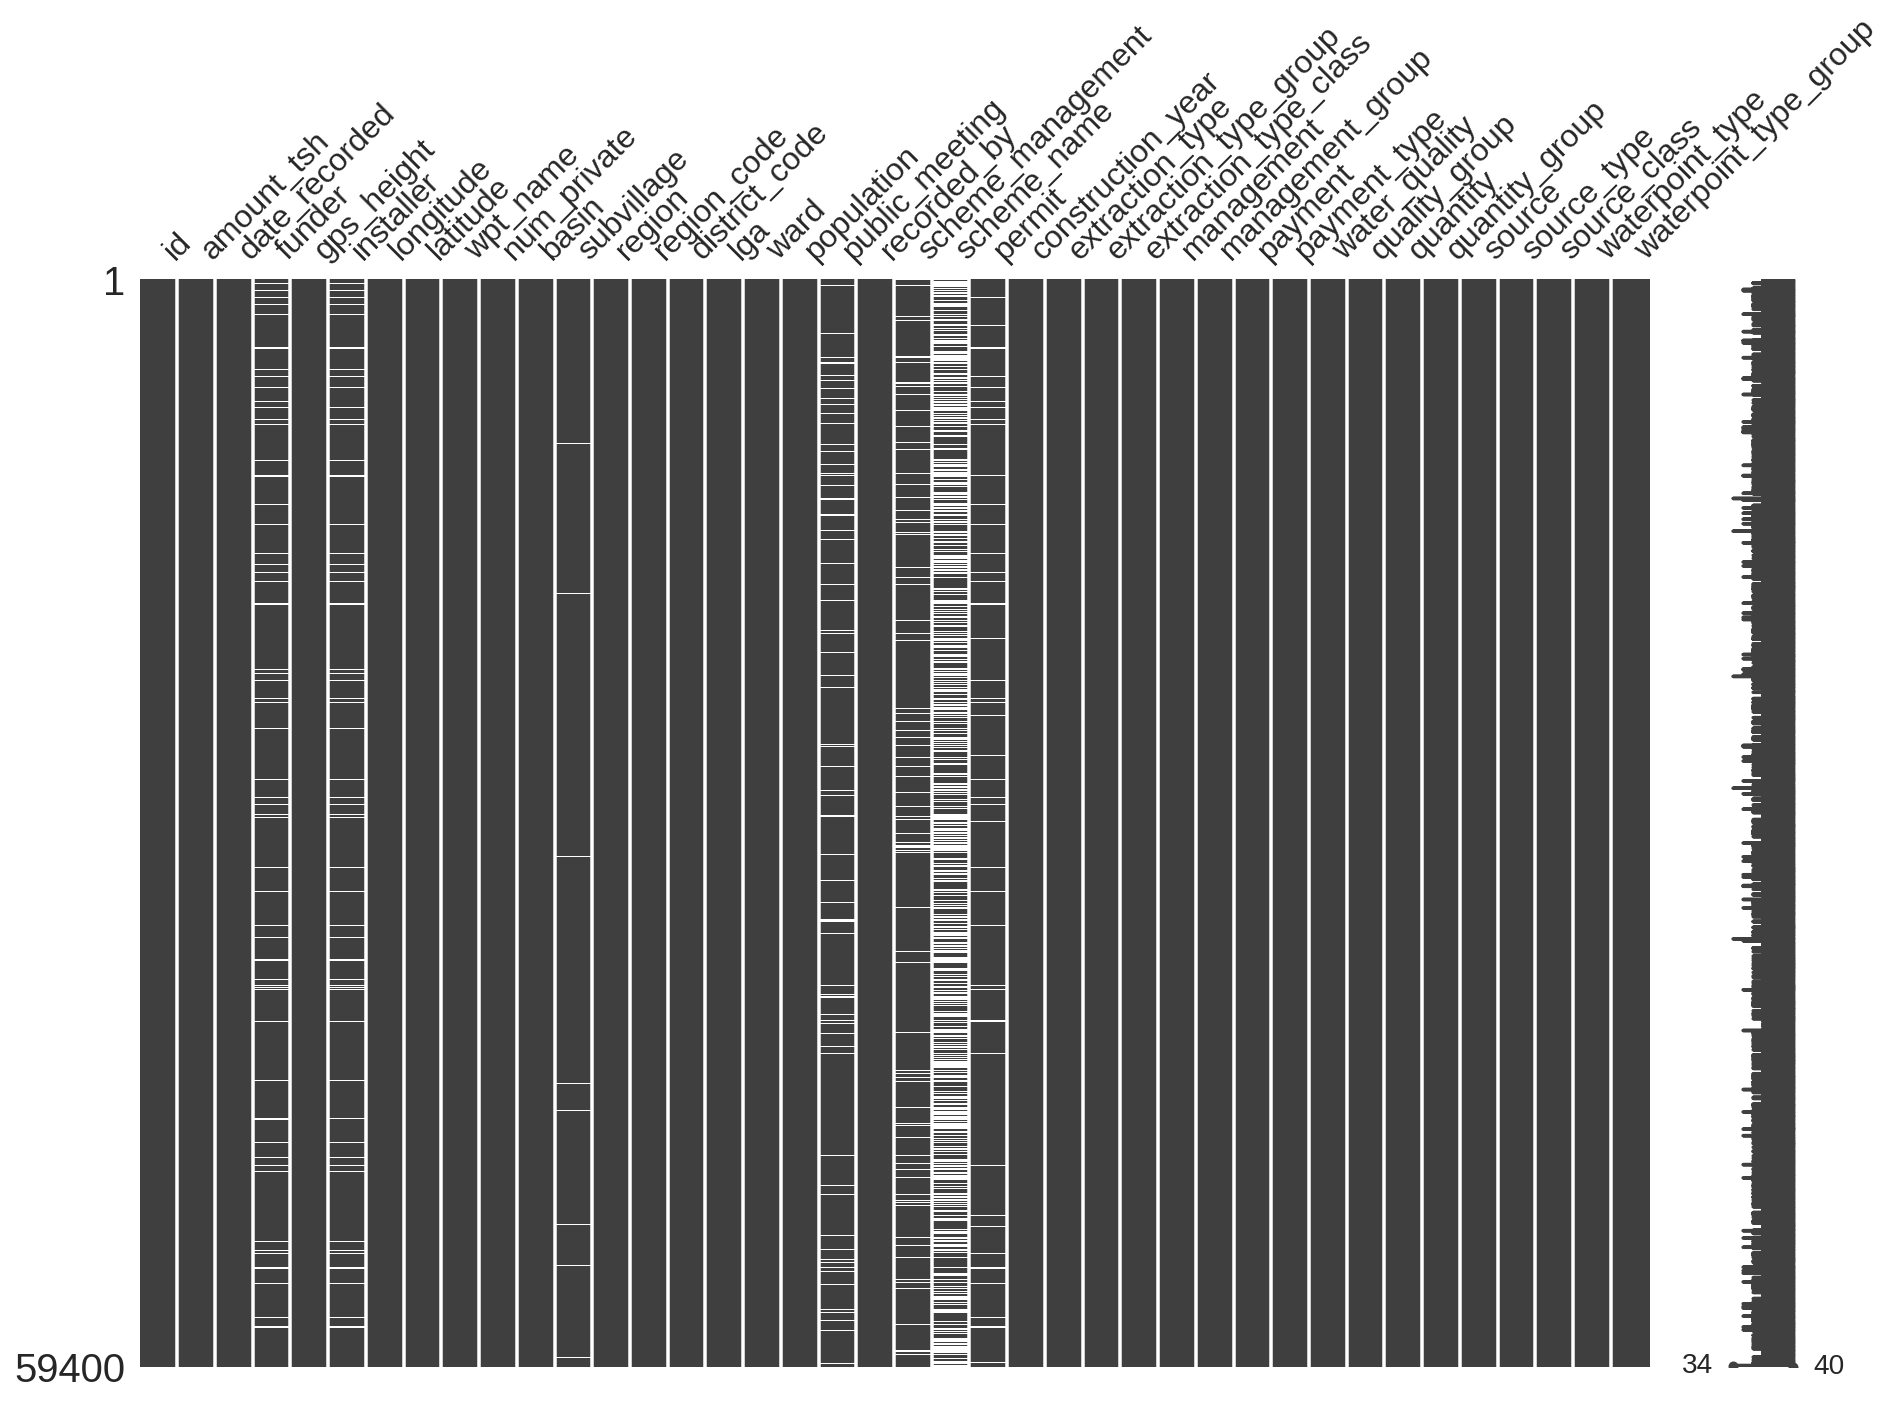

In [0]:
msno.matrix(train_features,figsize=(15, 10));

Looks like funder and installer have the very similar locations of missing values, so we can use the similar imputation strategies for both.

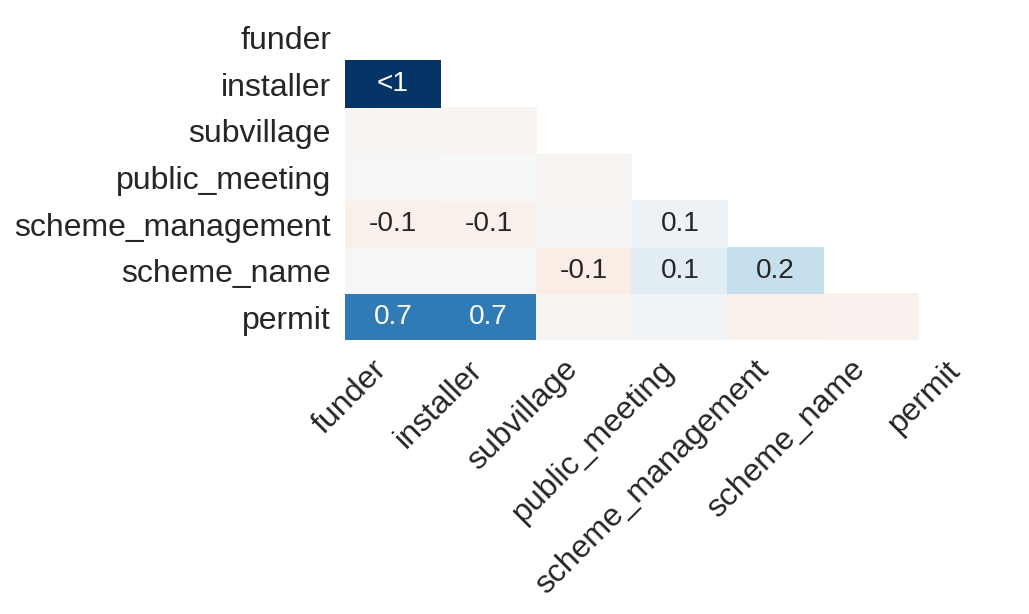

In [0]:
msno.heatmap(train_features,figsize=(6, 3));

<1 in the missing value correlation matrix indicate that there are only a few values
that are not correlated. We can also see in the matrix that funder and permit as well as installer and permit missing values are higly correlated (70%). Permit nan's are highly correlated with funder and installer as well, we can probably get away with the similar imputation strategies for all 3 column's missing values.

# Baseline model 1

In [0]:
# Check for nulls
df.isna().sum().sort_values()[-10:]

district_code            0
lga                      0
ward                     0
subvillage             465
permit                3719
public_meeting        4119
funder                4418
installer             4443
scheme_management     4816
scheme_name          35005
dtype: int64

In [0]:
# Drop scheme name, it's missing close to 50% of the rows
del df['scheme_name']

In [0]:
# Top 10 features with the highest cardinality
df.nunique().sort_values()[-10:]

population     1127
ward           2098
funder         2138
installer      2407
gps_height     2455
subvillage    21388
wpt_name      45600
latitude      71417
longitude     71418
id            73758
dtype: int64

For the baseline model, we could just drop the highly cardinal features. However, it's worth mentioning that latitude, longitude, gps_height, and district_code were relatively highly correlated (pearson) to our target, so may want to keep those in future models.

In [15]:
# Drop the least meaningful high cardinality categoricals
high_card = ['id','gps_height','latitude','longitude','wpt_name','funder',
             'installer','subvillage']
df.drop(high_card,inplace=True,axis=1)
df.shape

(73758, 32)

In [0]:
# One hot encode the data to give contrast to nans and categories
df = pd.get_dummies(df, drop_first=True, dummy_na=True)
df.shape

(73758, 2771)

That's a ton of new features, let's hope PCA can care take of this.

In [0]:
# Check for large variance
df.var().round().sort_values().round()[-5:]

num_private              134.0
region_code              308.0
population            223146.0
construction_year     905915.0
amount_tsh           8485567.0
dtype: float64

In [0]:
# Check for large means
df.mean().round().sort_values().round()[-5:]

district_code           6.0
region_code            15.0
population            181.0
amount_tsh            319.0
construction_year    1300.0
dtype: float64

There are a few columns with very high variance and means that greatly deviate from each other. We want to either transform them or use a scaler in the machine learning pipeline. Since I'm doing PCA, I chose the later.

In [0]:
# PCA the features
X_std = RobustScaler().fit_transform(df)

# Create a PCA instance that preserved 99.9% of the variance
pca = PCA(n_components=.999)
principalComponents = pca.fit_transform(X_std)

# Save components to a DataFrame
pca_df = pd.DataFrame(principalComponents)
pca_df.shape

(73758, 5)

Amazing. 2771 features were transformed into only 5 while preserving 99.9% of the variance.

In [0]:
# Set target, training, and testing variables
y_train = train_labels['status_group']
X_train = pca_df[:-14358]
X_test = pca_df[-14358:]
y_train.shape, X_train.shape, X_test.shape

((59400,), (59400, 5), (14358, 5))

In [0]:
# Instantiate a random forest with default number of trees
rf = RandomForestClassifier(10)
# Fit it to the training data
baseline_model = rf.fit(X_train, y_train)
# See the difference cross-validation makes
print("Score without cv:",baseline_model.score(X_train, y_train))
print('Score with 3-fold cv:',cross_val_score(baseline_model, X_train, y_train, cv=3).mean())

Score without cv: 0.931936026936027
Score with 3-fold cv: 0.7356565656565657


With a training time of about 2 seconds and a score well over .60, this is a great baseline model.

# Baseline model 2

In [16]:
# Reload the original data
df = pd.concat([train_features, test_features])

# Drop scheme name, it's missing close to 50% of the rows
del df['scheme_name']
del df['id']

# One hot encode the low cardinality categoricals
dummies = [
'basin', 'public_meeting', 'recorded_by', 'permit', 'extraction_type_class', 
'management_group', 'payment', 'payment_type', 
'water_quality', 'quality_group', 'quantity', 'quantity_group', 'source', 
'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group'
]
df = pd.get_dummies(df, drop_first=True, columns=dummies, dummy_na=True)

# Factorize the na cols
na_cols = ['funder','installer','subvillage','scheme_management']
df[na_cols] = df[na_cols].apply(lambda x: pd.factorize(x)[0])

# Encode the resst of the categories with Label encoder
encoder = LabelEncoder()
object_cols = df.select_dtypes('object').columns
df[object_cols] = df[object_cols].apply(encoder.fit_transform)
print('Shape of data without PCA:',df.shape)

# Change all numerics to float64 for better processing when scaling
numeric = df.select_dtypes(exclude='object').columns
df[numeric] = df[numeric].astype('float64')

# Reduce dimensionality with PCA instance to preserve 99.9% of the variance
X_std = StandardScaler().fit_transform(df)
pca = PCA(n_components=.999)
principalComponents = pca.fit_transform(X_std)

# Save components to a DataFrame
pca_df = pd.DataFrame(principalComponents)
print('Shape of data with PCA:',pca_df.shape)

# Split the data back into training and testing sets
y_train = train_labels['status_group']
X_train = pca_df[:-14358]
X_test = pca_df[-14358:]

# Instantiate a logistic regression classifier and get a cross validated accuracy score
logreg = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=500)
print('Score with 3-fold cv:',cross_val_score(logreg, X_train, y_train, cv=3).mean())

Shape of data without PCA: (73758, 118)
Shape of data with PCA: (73758, 72)
Score with 3-fold cv: 0.7253198653198654


# Fine-tuned model with additional feature engineering

In [0]:
# Reload the data
train_features = pd.read_csv('train_features.csv')
train_labels = pd.read_csv('train_labels.csv')
test_features = pd.read_csv('test_features.csv')
sample_submission = pd.read_csv('sample_submission.csv')

# Make combined df for easier processing
df = pd.concat([train_features, test_features])
train_features.shape, train_labels.shape, test_features.shape, \
sample_submission.shape, df.shape

((59400, 40), (59400, 2), (14358, 40), (14358, 2), (73758, 40))

In [0]:
# Cleaning and feature engineering process compiled from online resources
from sklearn.preprocessing import MinMaxScaler
df['gps_height'].replace(0.0, np.nan, inplace=True)
df['population'].replace(0.0, np.nan, inplace=True)
df['amount_tsh'].replace(0.0, np.nan, inplace=True)
df['gps_height'].fillna(df.groupby(['region', 'district_code'])['gps_height'].transform('mean'), inplace=True)
df['gps_height'].fillna(df.groupby(['region'])['gps_height'].transform('mean'), inplace=True)
df['gps_height'].fillna(df['gps_height'].mean(), inplace=True)
df['population'].fillna(df.groupby(['region', 'district_code'])['population'].transform('median'), inplace=True)
df['population'].fillna(df.groupby(['region'])['population'].transform('median'), inplace=True)
df['population'].fillna(df['population'].median(), inplace=True)
df['amount_tsh'].fillna(df.groupby(['region', 'district_code'])['amount_tsh'].transform('median'), inplace=True)
df['amount_tsh'].fillna(df.groupby(['region'])['amount_tsh'].transform('median'), inplace=True)
df['amount_tsh'].fillna(df['amount_tsh'].median(), inplace=True)
features=['amount_tsh', 'gps_height', 'population']
scaler = MinMaxScaler(feature_range=(0,20))
df[features] = scaler.fit_transform(df[features])
df['longitude'].replace(0.0, np.nan, inplace=True)
df['latitude'].replace(0.0, np.nan, inplace=True)
df['construction_year'].replace(0.0, np.nan, inplace=True)
df['latitude'].fillna(df.groupby(['region', 'district_code'])['latitude'].transform('mean'), inplace=True)
df['longitude'].fillna(df.groupby(['region', 'district_code'])['longitude'].transform('mean'), inplace=True)
df['longitude'].fillna(df.groupby(['region'])['longitude'].transform('mean'), inplace=True)
df['construction_year'].fillna(df.groupby(['region', 'district_code'])['construction_year'].transform('median'), inplace=True)
df['construction_year'].fillna(df.groupby(['region'])['construction_year'].transform('median'), inplace=True)
df['construction_year'].fillna(df.groupby(['district_code'])['construction_year'].transform('median'), inplace=True)
df['construction_year'].fillna(df['construction_year'].median(), inplace=True)
df['date_recorded'] = pd.to_datetime(df['date_recorded'])
df['years_service'] = df.date_recorded.dt.year - df.construction_year
garbage=['wpt_name','num_private','subvillage','region_code','recorded_by','management_group',
     'extraction_type_group','extraction_type_class','scheme_name','payment',
    'quality_group','quantity_group','source_type','source_class','waterpoint_type_group',
    'ward','public_meeting','permit','date_recorded','construction_year']
df.drop(garbage,axis=1, inplace=True)
df.waterpoint_type = df.waterpoint_type.str.lower()
df.funder = df.funder.str.lower()
df.basin = df.basin.str.lower()
df.region = df.region.str.lower()
df.source = df.source.str.lower()
df.lga = df.lga.str.lower()
df.management = df.management.str.lower()
df.quantity = df.quantity.str.lower()
df.water_quality = df.water_quality.str.lower()
df.payment_type=df.payment_type.str.lower()
df.extraction_type=df.extraction_type.str.lower()
df["funder"].fillna("other", inplace=True)
df["scheme_management"].fillna("other", inplace=True)
df["installer"].fillna("other", inplace=True)

# Drop id
del df['id']
df.shape

(73758, 20)

In [0]:
# Encode the categories with Label encoder
cat_encoder = LabelEncoder()
object_cols = df.select_dtypes('object').columns
df[object_cols] = df[object_cols].apply(cat_encoder.fit_transform)

# Split the data back into training and testing sets
y_train = train_labels['status_group']
X_train = df[:-14358]
X_test = df[-14358:]
y_train.shape, X_train.shape, X_test.shape

((59400,), (59400, 20), (14358, 20))

In [0]:
# Instantiate classifiers

# XGBoost
xgb = XGBClassifier(objective = 'multi:softmax', booster = 'gbtree',
                    nrounds = 'min.error.idx', num_class = 4,
                    maximize = False, eval_metric = 'merror', eta = .2,
                    max_depth = 16, colsample_bytree = .4, n_jobs = -1)

# Best RandomForest hyperparams after overnight tpot autoML
rf = RandomForestClassifier(bootstrap=False, criterion='entropy',
                            max_features=0.15000000000000002, min_samples_leaf=3, 
                            min_samples_split=2, n_estimators=500, n_jobs=-1)

# Train the model
model = xgb.fit(X_train, y_train)
print('Score with 2-fold cv:',cross_val_score(model, X_train, y_train, cv=2).mean())

Score with 2-fold cv: 0.8034679939728009


In [0]:
# Predict on out of sample data
y_pred = model.predict(X_test)

# Generate submission to Kaggle
submission = sample_submission.copy()
submission['status_group'] = y_pred
submission.to_csv('submission.csv', index=False)

**Final note**: there are many intermedite steps missing from this notebook where I was testing a number of different approaches in different notebooks. My first approach was simply to one hot encode the low cardinality categoricals (including the missing values) and factorize the object columns. This feature engineering approach did not translate well to tree-based models however, and my model was overfitting by a large margin. After spending almost a full day engineering features to see my score go up locally, but not generalize well to the outside world, I got help from a few colleagues. My new feature engineering approach was a lot more robust to overfitting and the model was relatively tight and generalized well to out of sample data. This resulted in roughly ~.82 score on kaggle on 2 different sets of out-of-sample data. https://www.kaggle.com/c/ds2-predictive-modeling-challenge/leaderboard